In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from joblib import dump as jdump
import numpy as np
import pickle
import random
import os

In [2]:
# # Uncomment this box if the file is in google drive
# # Create your own direcotry in your google drive and change path2root var.
# path2root = "/content/drive/MyDrive/Projects/EyeTracker/"

In [3]:
# Uncomment this box if the file is in your local directory
path2root = "../../"

In [4]:
models_fol = "models/"
ibo_models_fol = "in_blink_out/"
raw_fol = "raw/"
trained_fol = "trained/"
selected_model_num = 1
dataset_fol = "dataset/"
ibo_data_fol = "in_blink_out data/"
chosen_inputs = [0, 1, 2, 6, 7, 8, 9]
r_train = 0.85
n_epochs = 5
patience = 3
min_brightness_ratio = 0.6
max_brightness_ratio = 1.6

In [5]:
x1_load = []
x2_load = []
y_load = []

dataset_dir = path2root + dataset_fol
dataset_subjects = os.listdir(dataset_dir)

for sbj in dataset_subjects:
    ibo_dir = dataset_dir + f"{sbj}/" + ibo_data_fol
    with open(ibo_dir + "x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(ibo_dir + "x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(ibo_dir + "y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_h, frame_w = x1_load.shape[:-1]

print(n_smp, frame_h, frame_w)

4500 48 44


In [6]:
x2_chs_inp = x2_load[:, chosen_inputs]

In [7]:
import matplotlib.pyplot as plt

0


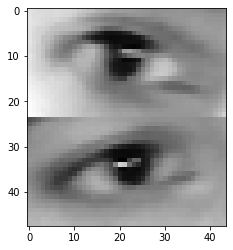

In [8]:
smp_num = 1
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)), cmap="gray")
plt.show()

In [9]:
# changing brightness
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(min_brightness_ratio, max_brightness_ratio)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [10]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

scalers = [x1_scaler, x2_scaler]

In [11]:
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y_load)

n_train = int(r_train * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]

print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)

(3825, 48, 44, 1) (675, 48, 44, 1) (3825, 7) (675, 7) (3825,) (675,)


In [12]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

In [13]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

In [14]:
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

In [18]:
raw_model_dir = path2root + models_fol + ibo_models_fol + raw_fol + f"model{selected_model_num}"

model = load_model(raw_model_dir)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 48, 44, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 22, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [16]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [19]:
results = model.fit(x_train_list,
                    y_train_ctg,
                    validation_data=(x_test_list, y_test_ctg),
                    epochs=n_epochs,
                    callbacks=cb)

Epoch 1/5
120/120 [==============================] - 6s 45ms/step - loss: 0.8797 - acc: 0.5922 - val_loss: 0.8085 - val_acc: 0.6489
Epoch 2/5
120/120 [==============================] - 5s 44ms/step - loss: 0.7675 - acc: 0.6437 - val_loss: 0.6842 - val_acc: 0.7007
Epoch 3/5
120/120 [==============================] - 5s 44ms/step - loss: 0.6313 - acc: 0.7425 - val_loss: 0.5879 - val_acc: 0.9437
Epoch 4/5
120/120 [==============================] - 5s 44ms/step - loss: 0.5772 - acc: 0.9035 - val_loss: 0.5998 - val_acc: 0.8785
Epoch 5/5
120/120 [==============================] - 5s 44ms/step - loss: 0.5400 - acc: 0.9145 - val_loss: 0.4587 - val_acc: 0.9585


In [20]:
yhat_train = model.predict(x_train_list).argmax(1)
yhat_test = model.predict(x_test_list).argmax(1)

Test
1
1


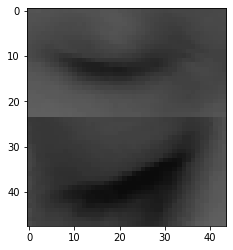

In [21]:
smp_num = 80
print("Test")
print(y_test[smp_num])
print(yhat_test[smp_num])
plt.imshow(
    (x1_test[smp_num].reshape((frame_h, frame_w)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

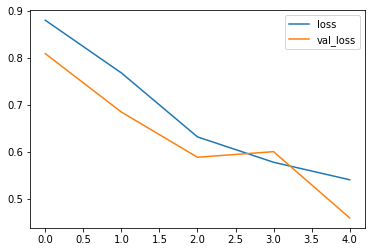

In [22]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

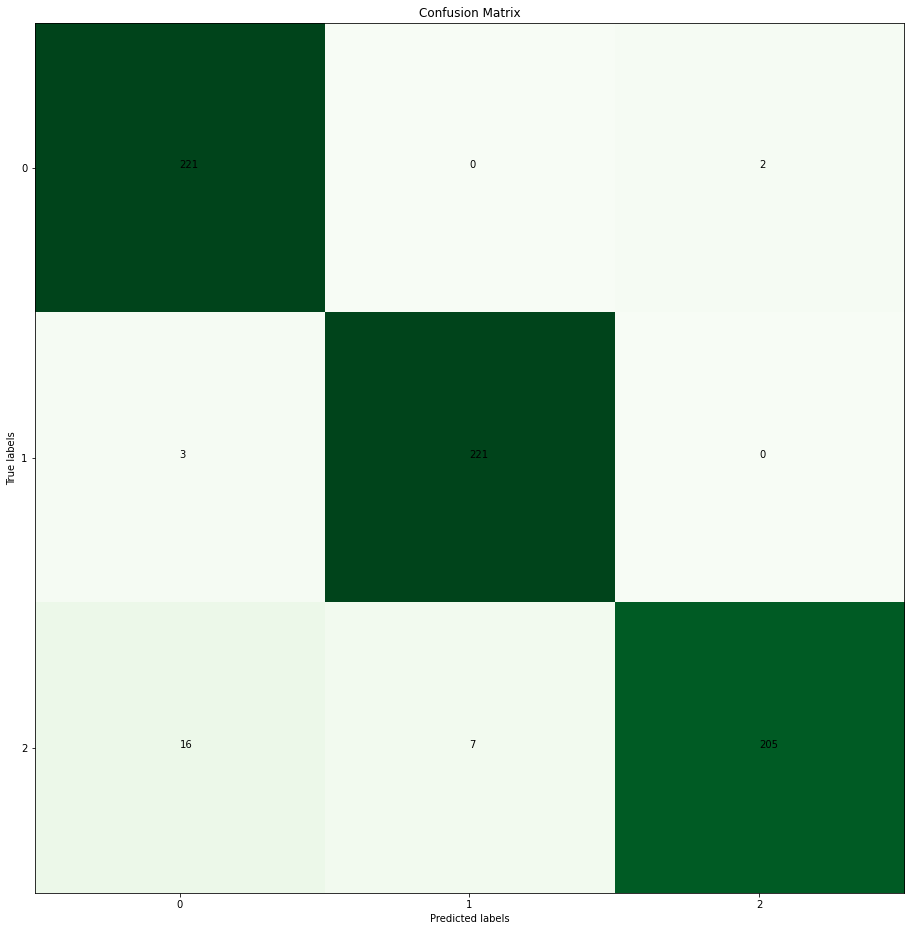

In [23]:
from sklearn.metrics import confusion_matrix

n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16,16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
    for j in range(n_class):
        plt.text(i, j, cm_test[j][i])

In [25]:
trained_dir = path2root + models_fol + ibo_models_fol + trained_fol
if not os.path.exists(trained_dir):
    os.mkdir(trained_dir)

In [29]:
models_numbers = []
models_name = os.listdir(trained_dir)
if models_name:
    for mn in models_name:
        if mn[:5] == "model":
            mn0 = int(mn[5:6])
            models_numbers.append(mn0)
    max_num = max(models_numbers)
else:
    max_num = 0

model.save(trained_dir + f"model{max_num+1}")
scalers_dir = path2root + models_fol + ibo_models_fol + trained_fol + f"scalers{max_num+1}.bin"
jdump(scalers, scalers_dir)

['model1', 'scalers1.bin']
INFO:tensorflow:Assets written to: ../../models/in_blink_out/trained/model2\assets


['../../models/in_blink_out/trained/scalers2.bin']